In [1]:
import domain_adapt_run.domain_adapt_run.constants as constants
cache_folder_name = 'no_projection'
seed = 44

In [2]:
import autograd.numpy as np
np.random.seed(seed)
import python_utils.python_utils.basic as basic
import python_utils.python_utils.caching as caching
log_folder = '%s/%s' % (constants.cache_folder, cache_folder_name)
caching.init(constants.cache_folder, constants.which_hash, basic.archiver(log_folder))
%load_ext autoreload
%autoreload 2

[Errno 17] File exists: '/Users/fultonw/Documents/projects/runs/domain_adapt_run/cache/no_projection'


In [3]:
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display_pretty, display_html
import python_utils.python_utils.basic as basic
import pandas as pd
import pdb
import itertools
import functools
import scipy.stats, scipy
import cvxopt
import domain_adapt.domain_adapt.kernels as kernels
import pymanopt
import pprint, autograd
import scipy.optimize
import domain_adapt.domain_adapt.SDR_data as SDR_data
import domain_adapt.domain_adapt.SDR_constructor as SDR_constructor
import sklearn
from sklearn import grid_search, linear_model, pipeline
from sklearn.metrics import roc_curve, auc

Couldn't import dot_parser, loading of dot files will not be possible.


/Users/fultonw/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/fultonw/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [4]:
# get data
import data.readmissions.readmissions.fxns as readmissions_data
num_source = 500
num_target = 500
#source_data = readmissions_data.bwh_orig_data()
source_data = readmissions_data.mgh_data()
source_data = source_data.reindex(np.random.permutation(source_data.index))
#target_data = readmissions_data.bwh_orig_data()
target_data = source_data
#target_data = readmissions_data.mgh_data()
#target_data = target_data.reindex(np.random.permutation(target_data.index))
source_X_df = pd.concat((source_data.iloc[0:num_source,0:-1], pd.DataFrame({'bias':np.ones(num_source)},index=source_data.index[0:num_source])),axis=1, join='inner')
target_X_df = pd.concat((target_data.iloc[0:num_target,0:-1], pd.DataFrame({'bias':np.ones(num_target)},index=target_data.index[0:num_target])),axis=1, join='inner')
feature_names = source_X_df.columns
source_X = source_X_df.values
target_X = target_X_df.values
source_y = source_data.iloc[0:num_source,-1].values
target_y = target_data.iloc[0:num_target,-1].values
print source_X.shape, source_y.shape
feature_names = source_X_df.columns
shift_X, shift_y = kernels.matrices_to_shift_Xy(source_X, target_X, source_y, target_y)

(500, 38) (500,)


In [5]:
print source_X_df.shape, source_X_df.columns.shape
feature_names.shape

(500, 38) (38,)


(38,)

In [6]:
# constants not cross validated
#num_trials = 1
#num_anneals = 1
B_max = 10
KMM_eps = 0.001
#desired_dim = 5
#lin_solver = lambda A,b: scipy.sparse.linalg.lsmr(A,b)[0]
#cvxopt_solver = kernels.cvxopt_solver
#get_KMM_get_K = lambda P,step, xs_train, xs_test: functools.partial(kernels.get_gaussian_K, 1.*kernels.median_distance(np.dot(np.vstack((xs_train,xs_test)),P),np.dot(np.vstack((xs_train,xs_test)),P)))
#get_SDR_get_K = lambda P,step, xs1, xs2: lambda xs1, xs2: xs1
#get_SDR_get_Ky = lambda P,step, ys1, ys2: lambda ys1, ys2: ys1
get_weight_estimator_get_K = lambda us_train, us_test: functools.partial(kernels.get_gaussian_K, kernels.median_distance(us_train, us_test))
weight_estimator = lambda us_train, us_test: kernels.get_KMM_ws(B_max, KMM_eps, get_weight_estimator_get_K(us_train,us_test), us_train, us_test)
def downstream_estimator_scorer(estimator, shift_X, shift_y, fit_params):
    source_X, target_X, source_y, target_y, source_ws = kernels.shift_Xy_to_matrices(shift_X, shift_y, weights=True)
    return kernels.logloss(source_y, estimator.source_predict(shift_X), source_ws)
downstream_estimator_params = {'C':np.exp2([-2,0,2,4,6])}
downstream_estimator = grid_search.GridSearchCV(kernels.shiftLogisticRegression(fit_intercept=False), param_grid=downstream_estimator_params, cv=2, scoring=downstream_estimator_scorer)

In [7]:
#
#regs = [0.1,1.,5.,10.,25.]
regs = [1.]
#tradeoffs = [0.1,1.,10]
#tradeoffs = [0.001]

In [8]:
#
def get_pipeline_param():
    #obj_from_wsopt_and_Ks, dobj_dwsopt, get_dobj_dP_thru_Ku = SDR_constructor.get_logreg_obj_and_gradients(lin_solver, cvxopt_solver, tradeoff, reg)
    #horse = functools.partial(SDR_constructor.get_noplot_SDR_horse, desired_dim, num_trials, num_anneals, lin_solver, cvxopt_solver, B_max, KMM_eps, get_KMM_get_K, get_SDR_get_K, get_SDR_get_Ky, obj_from_wsopt_and_Ks, dobj_dwsopt, get_dobj_dP_thru_Ku)
    #downstream_estimator_params = {'C':[reg]}
    #downstream_estimator = grid_search.GridSearchCV(kernels.shiftLogisticRegression(fit_intercept=False), param_grid=downstream_estimator_params, cv=2, scoring=downstream_estimator_scorer)
    return {'weighted_estimator__downstream_estimator':[downstream_estimator],'weighted_estimator__weight_estimator':[weight_estimator]}
    #return {'projection_estimator__horse':[horse],'weighted_estimator__downstream_estimator':[downstream_estimator],'weighted_estimator__weight_estimator':[weight_estimator]}

In [9]:
# 
#cv_base_estimator = pipeline.Pipeline([('projection_estimator',kernels.projection_estimator(feature_names=feature_names)),('weighted_estimator',kernels.weighted_estimator())])
cv_base_estimator = pipeline.Pipeline([('weighted_estimator',kernels.weighted_estimator())])
cv_estimator_params = [get_pipeline_param()]
#cv_estimator_params = [get_pipeline_param(reg, tradeoff) for tradeoff in tradeoffs for reg in regs]
use_frac = 0.05
def shift_scorer(loss, estimator, shift_X, shift_y):
    use_shift_X = shift_X[0:int(use_frac*len(shift_X))]
    use_shift_y = shift_y[0:int(use_frac*len(shift_y))]
    ys_hat = estimator.predict(use_shift_X) # assumes estimator predicts target, not source
    source_X, target_X, source_y, target_y = kernels.shift_Xy_to_matrices(use_shift_X, use_shift_y)
    return loss(target_y, ys_hat) 
estimator_scorer = functools.partial(shift_scorer, kernels.logloss)
cv_estimator = grid_search.GridSearchCV(cv_base_estimator, param_grid=cv_estimator_params, cv=2, scoring=estimator_scorer)

cv 0


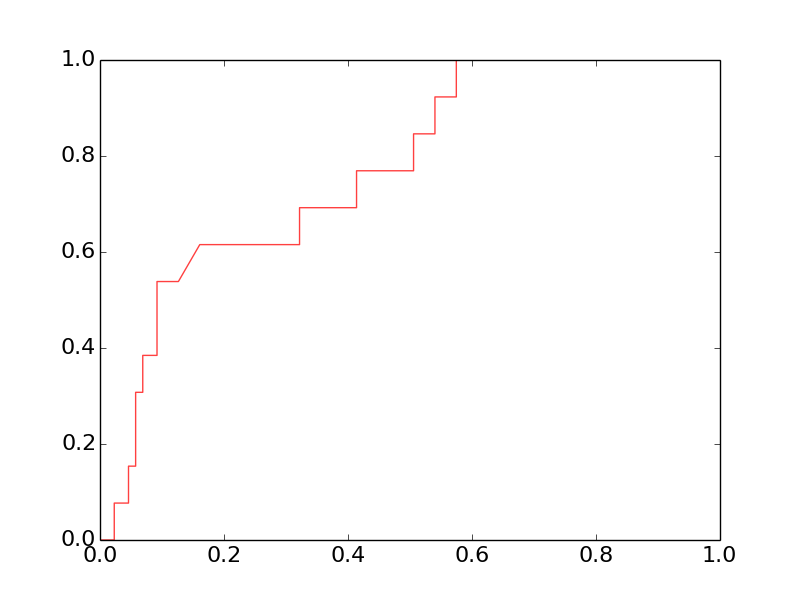

cv 1


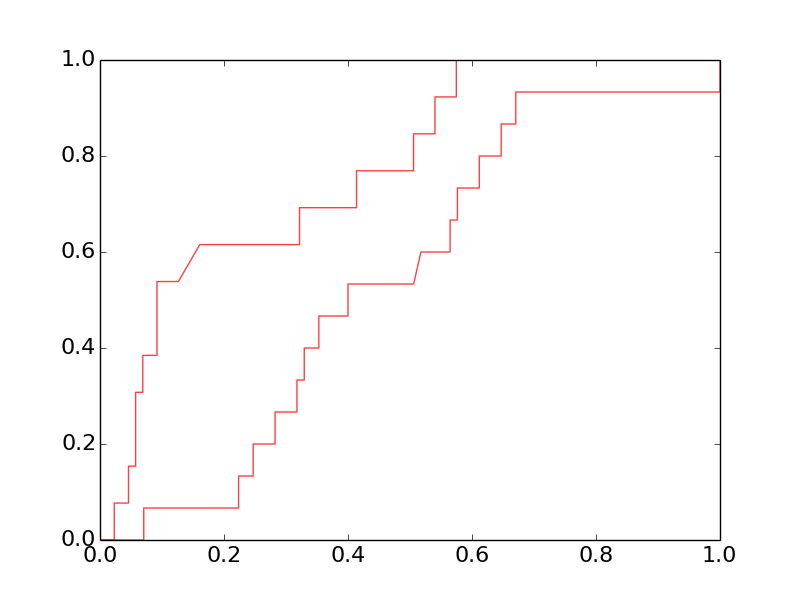

cv 2


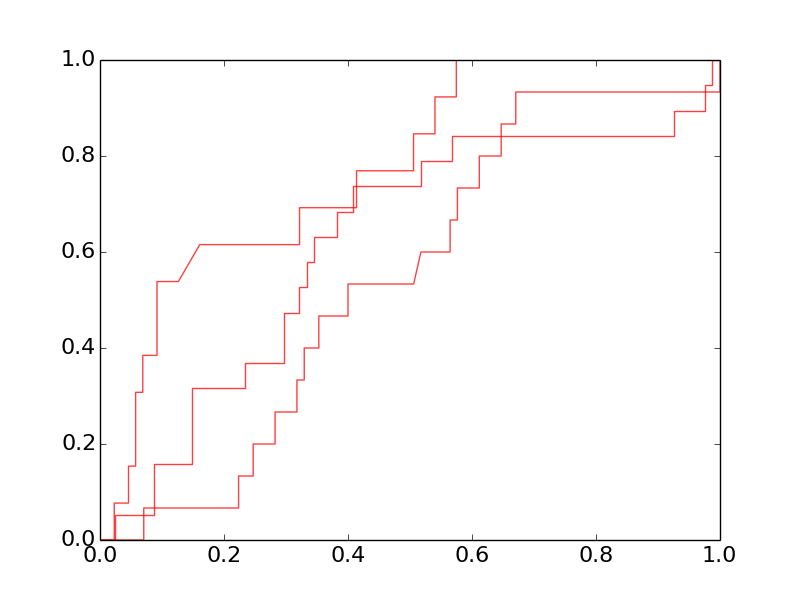

cv 3


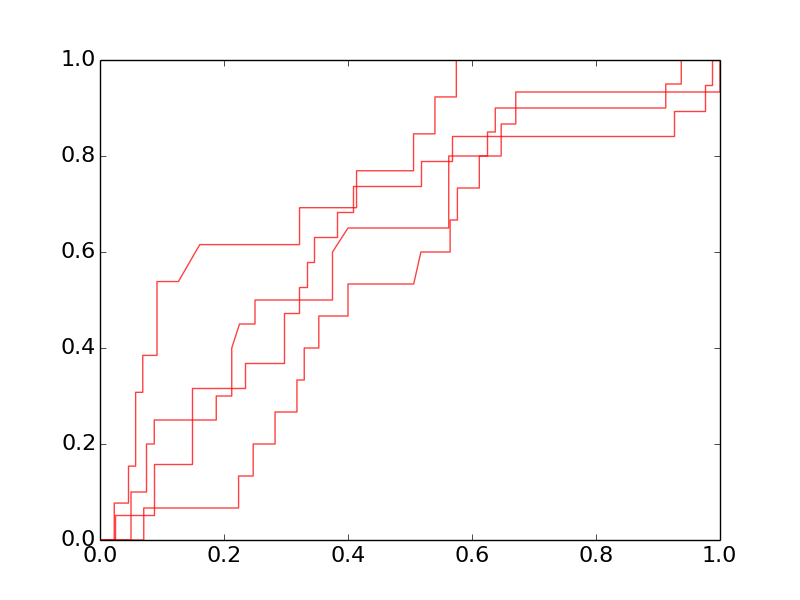

cv 4


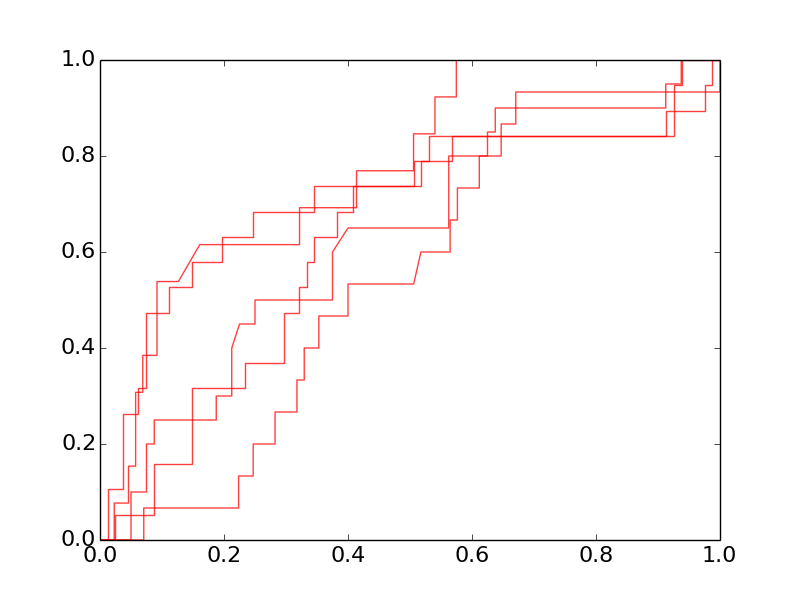

0    0.774094
1    0.546275
2    0.619233
3    0.632188
4    0.721897
dtype: float64 mean: 0.658737267292 std: 0.0802616146059


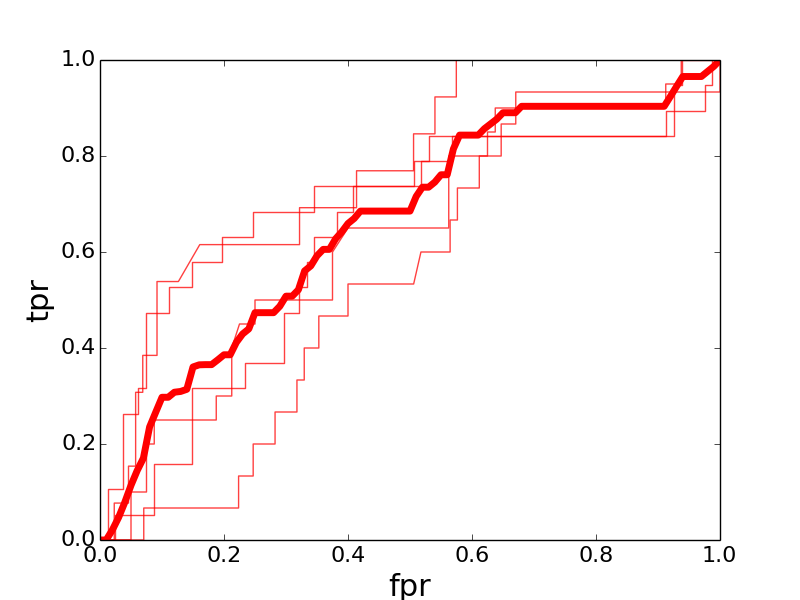

In [10]:
from scipy import interp
import matplotlib
matplotlib.rcParams.update({'font.size': 16})
fig, ax = plt.subplots()
fpr_points = np.linspace(0.,1.,101)
roc_curves = []
auc_vals = []
color = 'r'
label = 'asdf'
from sklearn.cross_validation import KFold
outer_cv = sklearn.cross_validation.KFold(num_source, 5)
for (i,(train, test)) in enumerate(reversed(list(outer_cv))):
    print 'cv', i
    shift_X_train, shift_y_train = [shift_X[idx] for idx in train], [shift_y[idx] for idx in train]
    shift_X_test, shift_y_test = [shift_X[idx] for idx in test], [shift_y[idx] for idx in test]
    cv_estimator.fit(shift_X_train, shift_y_train)
    target_y_test_hat = cv_estimator.predict(shift_X_test)
    source_X_test, target_X_test, source_y_test, target_y_test = kernels.shift_Xy_to_matrices(shift_X_test, shift_y_test)
    fpr, tpr, thresholds = roc_curve(target_y_test, target_y_test_hat)
    auc_vals.append(auc(fpr,tpr))
    roc_curves.append(interp(fpr_points, fpr, tpr))
    ax.plot(fpr, tpr, color = color, alpha=0.75, zorder=np.random.random())
    basic.display_fig_inline(fig)
roc_curves_df = pd.DataFrame(roc_curves, columns=fpr_points)
ax.plot(fpr_points, roc_curves_df.mean(), linewidth=5, color=color, label=label)
ax.set_xlabel('fpr',fontsize=22)
ax.set_ylabel('tpr',fontsize=22)
print pd.Series(auc_vals), 'mean:', np.mean(auc_vals), 'std:', np.std(auc_vals)
basic.display_fig_inline(fig)